In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.lstm_forecasting import LSTMTimeSeries
from src.xgb_forecasting import XGBoostModel
from sklearn.metrics import mean_squared_error
from src.preprocess import *
from src.add_features import *
# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [3]:
def treat_nan_convention(convention_df):
    # Keep only data for the specific arc
    convention_df = convention_df.loc[convention_df['Identifiant arc'] == 5671, :]

    # Convert datetime column to timezone-aware timestamps
    convention_df['Date et heure de comptage'] = pd.to_datetime(
        convention_df['Date et heure de comptage'], errors='coerce', utc=True
    )

    # Sort chronologically
    convention_df = convention_df.sort_values(by=['Date et heure de comptage'])

    # Define date ranges (full days)
    start_1 = pd.Timestamp('2024-12-06T00:00:00+01:00')  # start of first day
    end_1 = pd.Timestamp('2025-02-11T23:59:59+01:00')    # end of last day
    cutoff_2 = pd.Timestamp('2025-05-21T00:00:00+01:00') # start of second period

    # Filter data for both periods (full days)
    df_period1 = convention_df[
        (convention_df['Date et heure de comptage'] >= start_1) &
        (convention_df['Date et heure de comptage'] <= end_1)
    ]
    df_period2 = convention_df[
        convention_df['Date et heure de comptage'] >= cutoff_2
    ]

    # Concatenate both periods
    convention_df = pd.concat([df_period1, df_period2]).reset_index(drop=True)

    return convention_df


# Apply the function
convention_df = treat_nan_convention(convention_df)


In [4]:
df_champs_lstm=pipeline(convention_df, window=3, fill_hours=False)
df_champs_xgb = pipeline(convention_df,window=3,fill_hours=False)

# XGBoost model

Train set: (4992, 25), Test set: (72, 25) (72 hours)
Débit horaire : RMSE = 115.91, Mean = 421.50, Relative Error = 27.50%
Taux d'occupation : RMSE = 2.09, Mean = 4.08, Relative Error = 51.19%


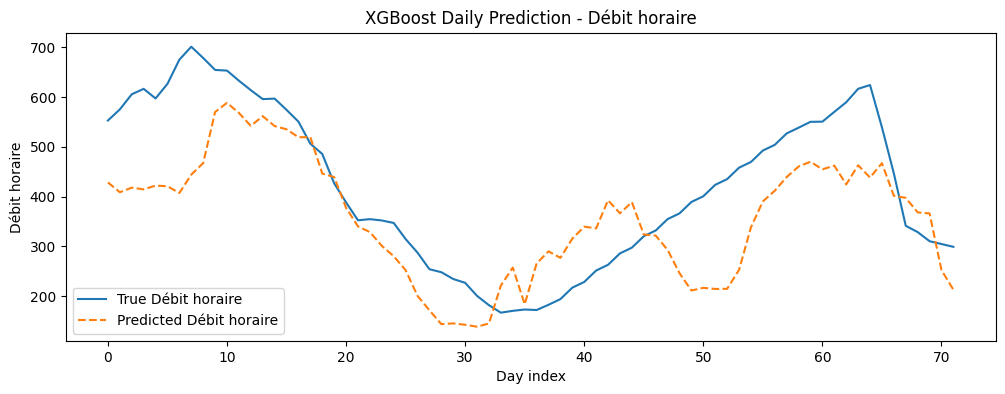

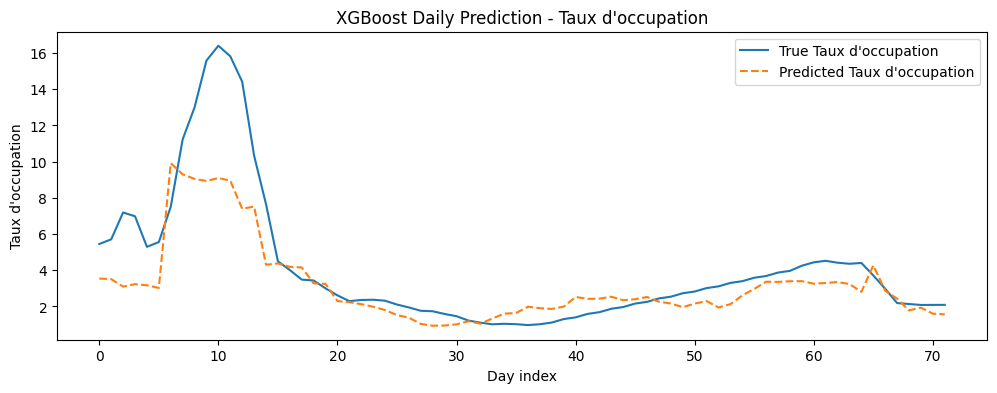

In [5]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

features_xgb = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]

df_xgb = df_champs_xgb.copy()

# Lags à créer (en heures)
lags_hours = [72,168]  # 1h, 3h, 1 jour, 2 jours, 1 semaine

for target in targets:
    for lag in lags_hours:
        col_name = f"{target}_lag_{lag}h"
        df_xgb[col_name] = df_xgb[target].shift(lag)
        features_xgb.append(col_name)

# Supprimer les lignes contenant des NaN générés par les lags
df_xgb = df_xgb.dropna(subset=[f"{t}_lag_{lag}h" for t in targets for lag in lags_hours] + targets).copy()


xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [6]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 111.18, std = 50.80 | MAE mean = 88.96, std = 44.90 | 
 MAPE mean = 35.98%, std = 20.82% | RMSE/mean = 27.94%, std = 10.68
Taux d'occupation : CV RMSE mean = 1.77, std = 0.78 | MAE mean = 1.18, std = 0.53 | 
 MAPE mean = 60.84%, std = 39.82% | RMSE/mean = 47.86%, std = 13.08


# LSTM time series

In [7]:
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

targets = ['Débit horaire', "Taux d'occupation"]

features = [
        'hour_sin', 'hour_cos', 
        'weekday_sin', 'weekday_cos', 
        'month_sin', 'month_cos', 
        'dayofyear_sin', 'dayofyear_cos',
        'is_weekend', 'is_holiday',
        'Vacances Scolaires Paris', 
        'temperature_2m (°C)', 'wind_speed_10m (km/h)',
        'precipitation (mm)', 'cloud_cover (%)',
        'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
        "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"]


In [8]:
final_eval_size = 72
seq_length = 168

# On garde les 168h avant la période finale pour le contexte
context_start = -(seq_length + final_eval_size)
context_end = -final_eval_size

train_val_df = df_champs_lstm.iloc[:-final_eval_size].copy()   # tout ce qui est AVANT le contexte
#context_df = df_champs.iloc[context_start:context_end].copy()  # les 168h de contexte
final_eval_df = df_champs_lstm.iloc[-final_eval_size:].copy()       # les 72h à prédire

print(f"Train: {train_val_df.shape},  Eval: {final_eval_df.shape}")

lstm_model = LSTMTimeSeries(
    features=features,
    targets=targets,
    seq_length=seq_length,
    pred_length=final_eval_size
)

Train: (5160, 53),  Eval: (72, 53)


In [25]:
df_champs_orig=pipeline(convention_df, window=0, fill_hours=True)
df_or = df_champs_orig.iloc[:-final_eval_size].copy()
lstm_model.cross_validate(train_val_df,df_or,epochs=30,batch_size=32)

3661
3950
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

===== Fold 1 =====
Débit horaire             RMSE: 193.77, MEAN: 533.62, MAPE: 48.64%, RMSE/mean: 36.31%
Taux d'occupation         RMSE: 3.01, MEAN: 5.14, MAPE: 76.20%, RMSE/mean: 58.47%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

===== Fold 2 =====
Débit horaire             RMSE: 202.91, MEAN: 302.58, MAPE: 99.46%, RMSE/mean: 67.06%
Taux d'occupation         RMSE: 2.82, MEAN: 2.10, MAPE: 178.70%, RMSE/mean: 134.16%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

===== Fold 3 =====
Débit horaire             RMSE: 147.15, MEAN: 322.02, MAPE: 43.48%, RMSE/mean: 45.69%
Taux d'occupation         RMSE: 1.72, MEAN: 2.42, MAPE: 64.58%, RMSE/mean: 70.92%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

===== Fold 4 =====
Débit horaire             RMSE: 83.22, MEAN: 415.59, MAPE: 18.91%, RMSE/mean: 20.02%
Taux d'occupation         RMSE: 1.79, MEAN: 3.60, MAPE: 33.00%, RMSE/mean: 49.57%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

===== Fold 5 =====
Débit horaire    

In [9]:
lstm_model.train_final(train_val_df, epochs=30, batch_size=32)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.5570 - mae: 0.5121 - mape: 246.4418
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.3239 - mae: 0.3732 - mape: 238.0875
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.2725 - mae: 0.3408 - mape: 212.7291
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.2418 - mae: 0.3215 - mape: 203.4034
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.2179 - mae: 0.3061 - mape: 200.5267
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.1997 - mae: 0.2949 - mape: 196.6649
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.1857 - mae: 0.2867 - mape: 193.6706
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1748 - mae: 0.2807 - mape: 191.0364
Epoch 9/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.1620 - mae: 0.2719 - mape: 187.8851
Epoch 10/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1612 - mae: 0.2716 - mape: 185.5529
Epo

In [10]:
y_pred = lstm_model.predict(train_val_df[-168:])  # entrée : les 168 dernières heures avant la période finale

print("\n📊 Évaluation finale par target :")
for i, target_name in enumerate(targets):
    y_true_i = final_eval_df[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

📊 Évaluation finale par target :
Débit horaire             RMSE: 260.34, MEAN: 421.50, MAPE: 54.25%, RMSE/mean: 61.77%
Taux d'occupation         RMSE: 4.49, MEAN: 4.08, MAPE: 71.15%, RMSE/mean: 110.01%


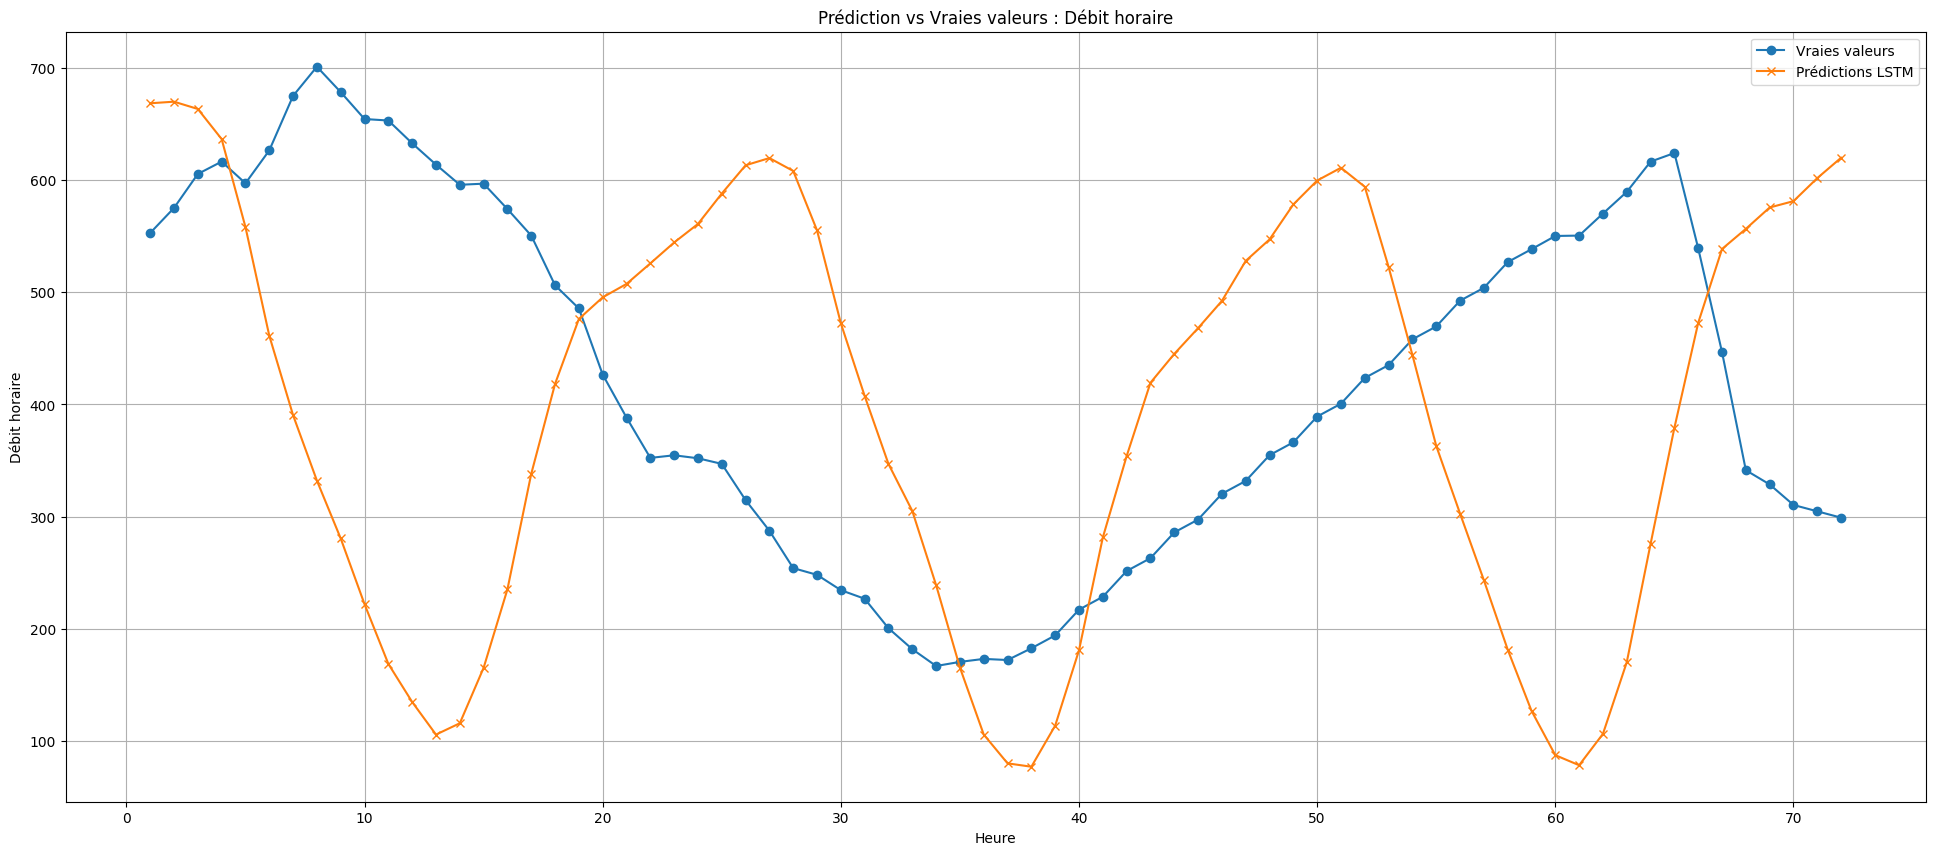

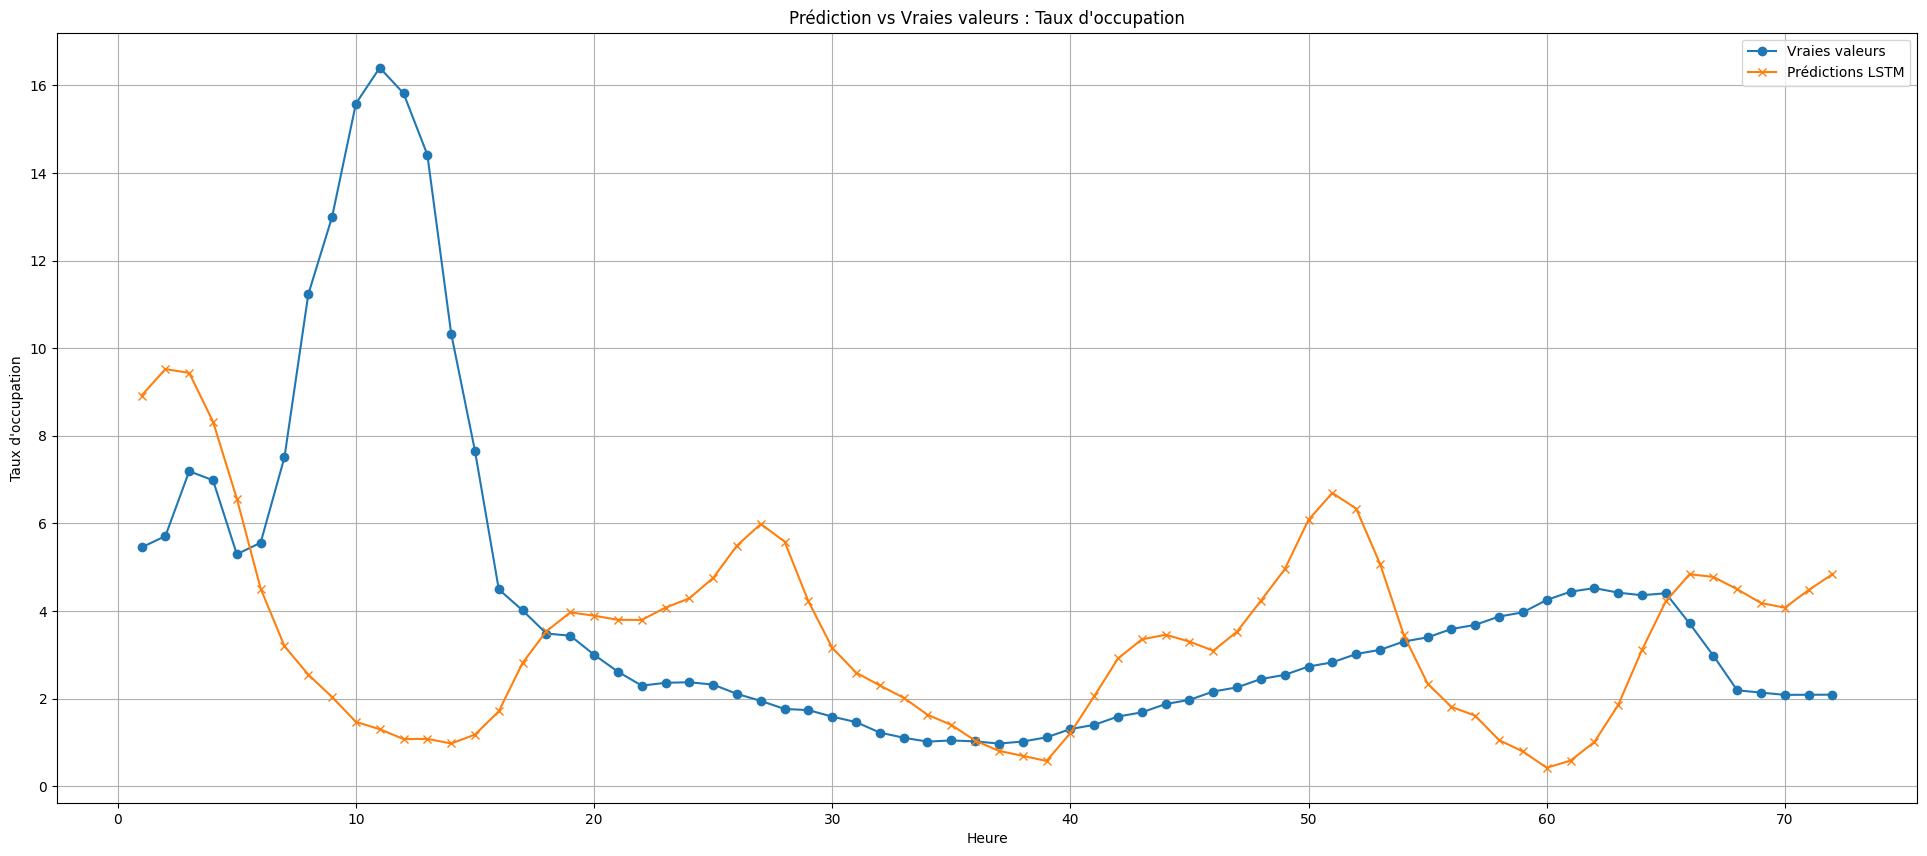

In [11]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()


In [12]:
df_champs_orig=pipeline(convention_df, window=0, fill_hours=True)
df_champs_orig_last = df_champs_orig.iloc[-72:,:]
print("\n📊 Évaluation finale par target (sans fuite de données) :")
for i, target_name in enumerate(targets):
    y_true_i = df_champs_orig_last[targets[i]].values
    y_pred_i = y_pred[:, i]
    metrics = LSTMTimeSeries.evaluate_metrics(y_true_i, y_pred_i, target_name=target_name)


📊 Évaluation finale par target (sans fuite de données) :
Débit horaire             RMSE: 262.79, MEAN: 421.39, MAPE: 55.04%, RMSE/mean: 62.36%
Taux d'occupation         RMSE: 4.65, MEAN: 4.07, MAPE: 73.55%, RMSE/mean: 114.40%


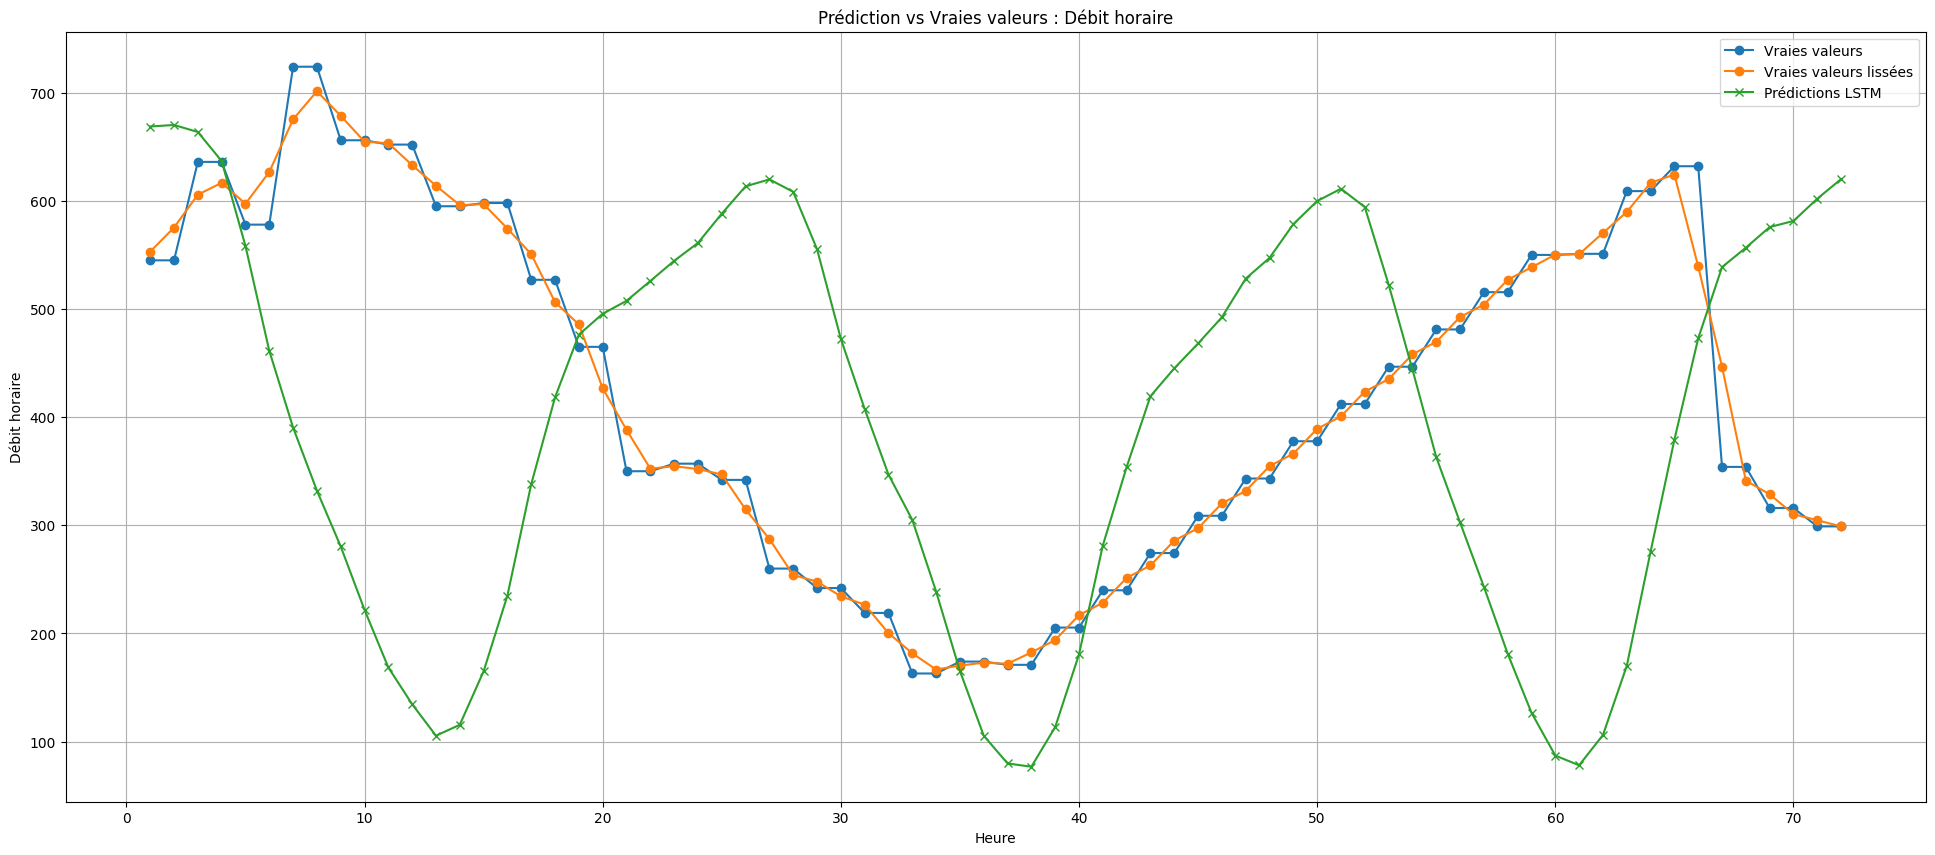

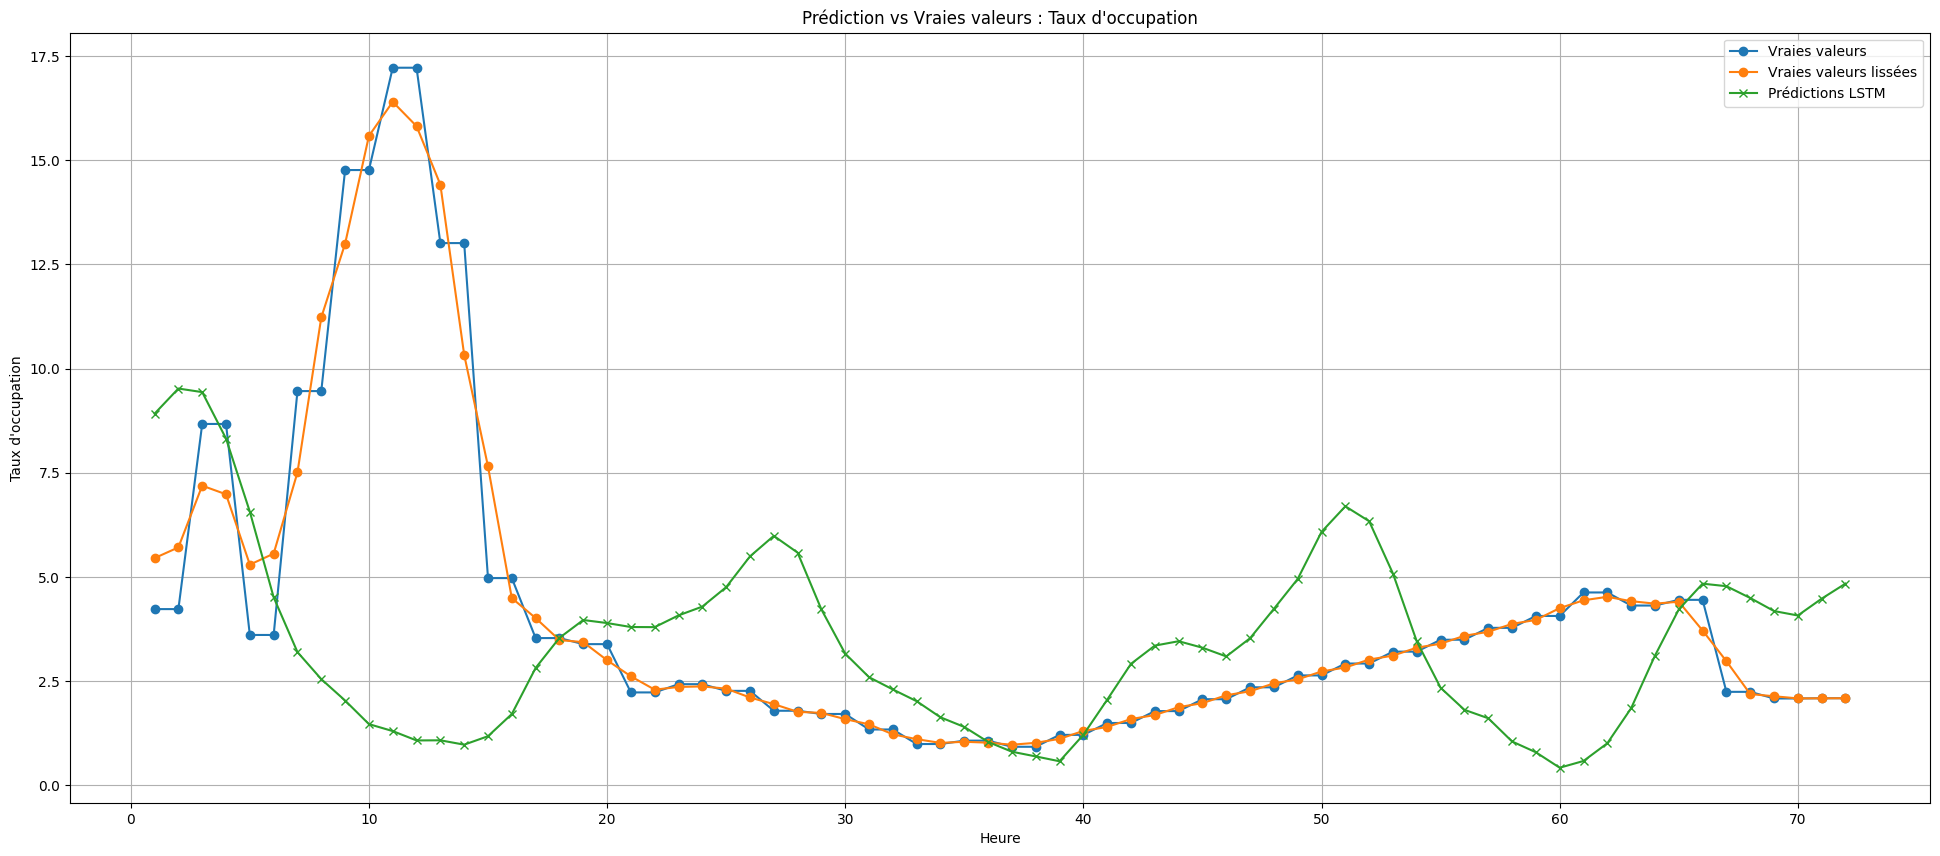

In [13]:
hours = np.arange(1, 73)
for i, target in enumerate(targets):
    plt.figure(figsize=(24,10))
    plt.plot(hours, df_champs_orig_last[targets[i]].values, marker='o', label='Vraies valeurs')
    plt.plot(hours, final_eval_df[targets[i]].values, marker='o', label='Vraies valeurs lissées')
    plt.plot(hours, y_pred[:, i], marker='x', label='Prédictions LSTM')
    plt.title(f'Prédiction vs Vraies valeurs : {target}')
    plt.xlabel('Heure')
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.show()